In [1]:
using PauliPropagation
using Base.Threads
using Plots

In [2]:
IBM_mitigated_vals = [1.01688859, 1.00387483, 0.95615886, 0.95966435, 0.83946763,
    0.81185907, 0.54640995, 0.45518584, 0.19469377, 0.01301832,0.01016334]
IBM_angles = [0.    , 0.1   , 0.2   , 0.3   , 0.4   , 0.5   , 0.6   , 0.7   , 0.8   , 1.    , 1.5707]

tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));


google_vals = [1, 0.9957248494988796,0.9785691808859784,0.9227771228638144,0.8549387301071374,
    0.7790027681081058,0.6093954499261214,0.4257824480390532,0.2090085348069826,0.0116245678393245, -4.8872551798147e-09]
google_angles = [0.000, 0.100, 0.200, 0.300, 0.400,0.500,0.600,0.700,0.800,1.000,1.571];

In [3]:
function kickedisingcircuit(nq, nl; topology=nothing)
    
    # just in case a topology is not provided
    if isnothing(topology)
        topology = bricklayertopology(nq)
    end
    
    # define a layer of parametrized Rx-gates
    xlayer(circuit) = append!(circuit, (PauliRotation([:X], [qind]) for qind in 1:nq))
    
    # define a layer of fixed RZZ(π/2)-gates
    zzlayer(circuit) = append!(circuit, (PauliRotation([:Z, :Z], pair, π/2) for pair in topology))
    
    # define the empty circuit
    circuit = Gate[]
    # append to the circuit
    for _ in 1:nl
        zzlayer(circuit)
        xlayer(circuit)
    end

    return circuit
end

kickedisingcircuit (generic function with 1 method)

In [4]:
# number of qubits
nq = 127
# the IBM Eagle topology
topology = ibmeagletopology
# 20 layers for the hardest simulation
nl = 20

# create the circuit
circuit = kickedisingcircuit(nq, nl; topology);
# count the number of parameters. Here only the RX gates, the RZZ are frozen to π/2
nparams = countparameters(circuit)

# define the observable (note the index is 62 if you start with 0)
pstr = PauliString(nq, :Z, 63)

PauliString(nqubits: 127, 1.0 * IIIIIIIIIIIIIIIIIIII...)

In [5]:
# perform one simulation
# the reason we make this into a function is so that the Julia garbage collector gets rid of `psum` after we leave the function
# otherwise it floats around in the global name space and takes up RAM
function onesimulation(circuit, pstr, thetas; min_abs_coeff=0, max_weight=Inf)
    # propagate
    psum = propagate(circuit, pstr, thetas; min_abs_coeff, max_weight)
    # overlap with the zero-state
    return overlapwithzero(psum)
end

onesimulation (generic function with 1 method)

In [6]:
# set the truncations
min_abs_coeff = 1e-4
max_weight = 8

# prepare everything and run
x_angles = LinRange(0, π/2, 20)
expectations = zeros(length(x_angles))
# multi-thread over the different x_angles
t = @timed @threads for ii in eachindex(x_angles)
    angle = x_angles[ii]
    thetas = ones(nparams) * angle
    @time expectations[ii] = onesimulation(circuit, pstr, thetas; min_abs_coeff, max_weight)
end

print("Total simulation time: ", t.time, " seconds")

  0.154852 seconds (352.35 k allocations: 19.149 MiB, 4.72% gc time, 2960.68% compilation time)
  0.480289 seconds (889.47 k allocations: 45.920 MiB, 1.52% gc time, 1467.07% compilation time)
  0.480659 seconds (897.33 k allocations: 47.587 MiB, 1.52% gc time, 1465.94% compilation time)
  0.496765 seconds (943.53 k allocations: 62.503 MiB, 1.47% gc time, 1331.44% compilation time)
  0.008510 seconds (35.03 k allocations: 9.265 MiB)
  0.063755 seconds (242.92 k allocations: 32.716 MiB, 11.47% gc time, 4668.24% compilation time)
  0.235814 seconds (497.76 k allocations: 46.420 MiB, 3.10% gc time, 2258.77% compilation time)
  0.188635 seconds (57.50 k allocations: 40.010 MiB, 2.76% gc time)
  0.926921 seconds (1.08 M allocations: 113.665 MiB, 1.63% gc time, 814.26% compilation time)
  0.480693 seconds (276.39 k allocations: 76.068 MiB, 3.15% gc time, 12.50% compilation time)
  0.174172 seconds (42.43 k allocations: 4.842 MiB)
  0.950300 seconds (73.73 k allocations: 7.554 MiB)
  2.255318 

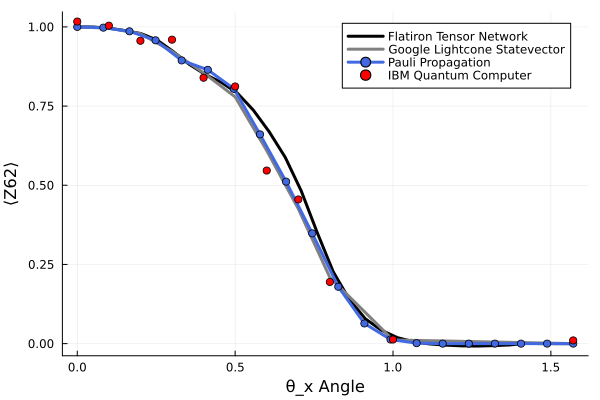

In [7]:
pl = plot(xlabel="θ_x Angle", ylabel="⟨Z62⟩")
plot!(tn_angles, tn_vals, label="Flatiron Tensor Network", color="black", linewidth=3)
plot!(google_angles, google_vals, label="Google Lightcone Statevector", color="grey", linewidth=3)
plot!(x_angles, expectations, marker=:circle, label="Pauli Propagation", linewidth=3, color="royalblue")
scatter!(IBM_angles, IBM_mitigated_vals, label="IBM Quantum Computer", color="Red", ms=4)
